## **3. Word2Vec**
1. 주어진 단어들을 word2vec 모델에 들어갈 수 있는 형태로 만듭니다.
2. CBOW, Skip-gram 모델을 각각 구현합니다.
3. 모델을 실제로 학습해보고 결과를 확인합니다.
4. 산점도를 그려 단어들의 대략적인 위치를 확인해봅니다

### **필요 패키지 import**

In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
# !pip install konlpy

In [3]:
from tqdm import tqdm
from konlpy.tag import Mecab,Twitter,Okt,Kkma
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

import torch
import copy
import numpy as np

### **데이터 전처리**



데이터를 확인하고 Word2Vec 형식에 맞게 전처리합니다.

In [4]:
train_data = [
  "정말 맛있습니다. 추천합니다.",
  "기대했던 것보단 별로였네요.",
  "다 좋은데 가격이 너무 비싸서 다시 가고 싶다는 생각이 안 드네요.",
  "완전 최고입니다! 재방문 의사 있습니다.",
  "음식도 서비스도 다 만족스러웠습니다.",
  "위생 상태가 좀 별로였습니다. 좀 더 개선되기를 바랍니다.",
  "맛도 좋았고 직원분들 서비스도 너무 친절했습니다.",
  "기념일에 방문했는데 음식도 분위기도 서비스도 다 좋았습니다.",
  "전반적으로 음식이 너무 짰습니다. 저는 별로였네요.",
  "위생에 조금 더 신경 썼으면 좋겠습니다. 조금 불쾌했습니다."       
]

test_words = ["음식", "맛", "서비스", "위생", "가격"]

Tokenization과 vocab을 만드는 과정은 이전 실습과 유사합니다.

In [5]:
tokenizer = Okt()

In [6]:
def make_tokenized(data):
  tokenized = []
  for sent in tqdm(data):
    tokens = tokenizer.morphs(sent, stem=True)
    tokenized.append(tokens)

  return tokenized

In [7]:
train_tokenized = make_tokenized(train_data)

100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


In [8]:
word_count = defaultdict(int)

for tokens in tqdm(train_tokenized):
  for token in tokens:
    word_count[token] += 1

100%|██████████| 10/10 [00:00<00:00, 125577.96it/s]


In [9]:
word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print(list(word_count))

[('.', 14), ('도', 7), ('이다', 4), ('좋다', 4), ('별로', 3), ('다', 3), ('이', 3), ('너무', 3), ('음식', 3), ('서비스', 3), ('하다', 2), ('방문', 2), ('위생', 2), ('좀', 2), ('더', 2), ('에', 2), ('조금', 2), ('정말', 1), ('맛있다', 1), ('추천', 1), ('기대하다', 1), ('것', 1), ('보단', 1), ('가격', 1), ('비싸다', 1), ('다시', 1), ('가다', 1), ('싶다', 1), ('생각', 1), ('안', 1), ('드네', 1), ('요', 1), ('완전', 1), ('최고', 1), ('!', 1), ('재', 1), ('의사', 1), ('있다', 1), ('만족스럽다', 1), ('상태', 1), ('가', 1), ('개선', 1), ('되다', 1), ('기르다', 1), ('바라다', 1), ('맛', 1), ('직원', 1), ('분들', 1), ('친절하다', 1), ('기념일', 1), ('분위기', 1), ('전반', 1), ('적', 1), ('으로', 1), ('짜다', 1), ('저', 1), ('는', 1), ('신경', 1), ('써다', 1), ('불쾌하다', 1)]


In [10]:
w2i = {}
for pair in tqdm(word_count):
  if pair[0] not in w2i:
    w2i[pair[0]] = len(w2i)

i2w={v:k for k,v in w2i.items()}

100%|██████████| 60/60 [00:00<00:00, 949653.74it/s]


In [11]:
print(train_tokenized)
print(w2i)

[['정말', '맛있다', '.', '추천', '하다', '.'], ['기대하다', '것', '보단', '별로', '이다', '.'], ['다', '좋다', '가격', '이', '너무', '비싸다', '다시', '가다', '싶다', '생각', '이', '안', '드네', '요', '.'], ['완전', '최고', '이다', '!', '재', '방문', '의사', '있다', '.'], ['음식', '도', '서비스', '도', '다', '만족스럽다', '.'], ['위생', '상태', '가', '좀', '별로', '이다', '.', '좀', '더', '개선', '되다', '기르다', '바라다', '.'], ['맛', '도', '좋다', '직원', '분들', '서비스', '도', '너무', '친절하다', '.'], ['기념일', '에', '방문', '하다', '음식', '도', '분위기', '도', '서비스', '도', '다', '좋다', '.'], ['전반', '적', '으로', '음식', '이', '너무', '짜다', '.', '저', '는', '별로', '이다', '.'], ['위생', '에', '조금', '더', '신경', '써다', '좋다', '.', '조금', '불쾌하다', '.']]
{'.': 0, '도': 1, '이다': 2, '좋다': 3, '별로': 4, '다': 5, '이': 6, '너무': 7, '음식': 8, '서비스': 9, '하다': 10, '방문': 11, '위생': 12, '좀': 13, '더': 14, '에': 15, '조금': 16, '정말': 17, '맛있다': 18, '추천': 19, '기대하다': 20, '것': 21, '보단': 22, '가격': 23, '비싸다': 24, '다시': 25, '가다': 26, '싶다': 27, '생각': 28, '안': 29, '드네': 30, '요': 31, '완전': 32, '최고': 33, '!': 34, '재': 35, '의사': 36, '있다': 37, '만족스럽다': 38, '상태

### 다음은 Word2Vec을 학습시키는 대표적인 방법인 Skipgram과 CBow를 다룹니다. 

* Cbow는 주변단어를 이용해, 주어진 단어를 예측하는 방법입니다.
* Skipgram은 중심 단어를 이용하여 주변 단어를 예측하는 방법입니다.
* 즉 데이터셋을 구성할때, input x 와 target y를 어떻게 설정하는지에 차이가 있습니다.

참고자료 

* https://simonezz.tistory.com/35 

* https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314 



실제 모델에 들어가기 위한 input을 만들기 위해 `Dataset` 클래스를 정의합니다.

In [12]:
class CBOWDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = [] # input word
    self.y = [] # target word

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
          self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
          self.y.append(id)

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수, 2 * window_size)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [13]:
class SkipGramDataset(Dataset):
  def __init__(self, train_tokenized, window_size=2):
    self.x = []
    self.y = None

    for tokens in tqdm(train_tokenized):
      token_ids = [w2i[token] for token in tokens]
      for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
          self.x.append(id)
          tokens_in_window = token_ids[i-window_size:i+window_size+1]
          y_tensor = torch.LongTensor(tokens_in_window[:window_size] + token_ids[-window_size:])
          one_hot = F.one_hot(y_tensor, num_classes=len(w2i))
          if self.y == None:
            self.y = one_hot
            self.y = torch.unsqueeze(self.y, 0)
          else:
            self.y = torch.concat((self.y, torch.unsqueeze(one_hot, 0)))

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
    self.y = self.y.type(torch.float)
    
  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

각 모델에 맞는 `Dataset` 객체를 생성합니다.

In [14]:
cbow_set = CBOWDataset(train_tokenized)
skipgram_set = SkipGramDataset(train_tokenized)
# print(list(cbow_set))
print(list(skipgram_set)[0])

100%|██████████| 10/10 [00:00<00:00, 2060.88it/s]

(tensor(0), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

### **모델 Class 구현**

차례대로 두 가지 Word2Vec 모델을 구현합니다.  


*   `self.embedding`: `vocab_size` 크기의 one-hot vector를 특정 크기의 `dim` 차원으로 embedding 시키는 layer.
*   `self.linear`: 변환된 embedding vector를 다시 원래 `vocab_size`로 바꾸는 layer.


In [15]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, dim):
    super(CBOW, self).__init__()
    self.embedding = nn.Embedding(vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, vocab_size)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x):  # x: (B, 2W)
    embeddings = self.embedding(x)  # (B, 2W, d_w)
    embeddings = torch.sum(embeddings, dim=1)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V)
    return output

In [16]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, dim, window_size=2):
    super(SkipGram, self).__init__()
    self.window_size = window_size
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(self.vocab_size, dim, sparse=True)
    self.linear = nn.Linear(dim, self.vocab_size * self.window_size * 2)

  # B: batch size, W: window size, d_w: word embedding size, V: vocab size
  def forward(self, x): # x: (B)
    embeddings = self.embedding(x)  # (B, d_w)
    output = self.linear(embeddings)  # (B, V * W)
    output = output.view(-1, self.window_size * 2, self.vocab_size)
    return output

두 가지 모델을 생성합니다.

In [17]:
cbow = CBOW(vocab_size=len(w2i), dim=256)
skipgram = SkipGram(vocab_size=len(w2i), dim=256)

### **모델 학습**

다음과 같이 hyperparamter를 세팅하고 `DataLoader` 객체를 만듭니다.

In [18]:
batch_size=4
learning_rate = 5e-4
num_epochs = 100
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

첫번째로 CBOW 모델 학습입니다.

In [19]:
cbow.train()
cbow = cbow.to(device)
optim = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):

  for batch in cbow_loader:
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = cbow(x)  # (B, V)
 
    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

  print(f"Epoch: {e}, Train loss: {loss.item()}")

print("Finished.")

Epoch: 1, Train loss: 4.992088317871094
Epoch: 2, Train loss: 4.861606121063232
Epoch: 3, Train loss: 4.733674049377441
Epoch: 4, Train loss: 4.608297824859619
Epoch: 5, Train loss: 4.485503196716309
Epoch: 6, Train loss: 4.365334510803223
Epoch: 7, Train loss: 4.24784517288208
Epoch: 8, Train loss: 4.133092880249023
Epoch: 9, Train loss: 4.021129608154297
Epoch: 10, Train loss: 3.911996841430664
Epoch: 11, Train loss: 3.8057146072387695
Epoch: 12, Train loss: 3.702279567718506
Epoch: 13, Train loss: 3.601658344268799
Epoch: 14, Train loss: 3.503791332244873
Epoch: 15, Train loss: 3.408600330352783
Epoch: 16, Train loss: 3.315992832183838
Epoch: 17, Train loss: 3.2258760929107666
Epoch: 18, Train loss: 3.138162612915039
Epoch: 19, Train loss: 3.0527822971343994
Epoch: 20, Train loss: 2.969682216644287
Epoch: 21, Train loss: 2.8888258934020996
Epoch: 22, Train loss: 2.8101918697357178
Epoch: 23, Train loss: 2.7337698936462402
Epoch: 24, Train loss: 2.659552812576294
Epoch: 25, Train los

다음으로 Skip-gram 모델 학습입니다.

In [20]:
skipgram.train()
skipgram = skipgram.to(device)
optim = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

for e in range(1, num_epochs+1):
  for batch in skipgram_loader:
    x, y = batch
    x, y = x.to(device), y.to(device) # (B, W), (B)
    output = skipgram(x)  # (B, V)
    optim.zero_grad()
    loss = loss_function(output, y)
    loss.backward()
    optim.step()

  print(f"Epoch: {e}, Train loss: {loss.item()}")

print("Finished.")

Epoch: 1, Train loss: 0.10619376599788666
Epoch: 2, Train loss: 0.10614388436079025
Epoch: 3, Train loss: 0.10609404742717743
Epoch: 4, Train loss: 0.10604425519704819
Epoch: 5, Train loss: 0.10599449276924133
Epoch: 6, Train loss: 0.10594478249549866
Epoch: 7, Train loss: 0.10589507967233658
Epoch: 8, Train loss: 0.10584545135498047
Epoch: 9, Train loss: 0.10579582303762436
Epoch: 10, Train loss: 0.10574626177549362
Epoch: 11, Train loss: 0.10569673031568527
Epoch: 12, Train loss: 0.10564723610877991
Epoch: 13, Train loss: 0.10559777170419693
Epoch: 14, Train loss: 0.10554834455251694
Epoch: 15, Train loss: 0.10549895465373993
Epoch: 16, Train loss: 0.1054496094584465
Epoch: 17, Train loss: 0.10540029406547546
Epoch: 18, Train loss: 0.105351023375988
Epoch: 19, Train loss: 0.10530178248882294
Epoch: 20, Train loss: 0.10525258630514145
Epoch: 21, Train loss: 0.10520342737436295
Epoch: 22, Train loss: 0.10515429824590683
Epoch: 23, Train loss: 0.1051052138209343
Epoch: 24, Train loss: 0

### **테스트**

학습된 각 모델을 이용하여 test 단어들의 word embedding을 확인합니다.

In [21]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = cbow.embedding(input_id)

  print(f"Word: {word}")
  print(emb.squeeze(0))

Word: 음식
tensor([ 0.6137,  0.0165,  0.8298, -2.0467, -0.3172, -1.1105, -0.6243,  0.8758,
         0.0183, -0.1240,  1.5317,  0.6455,  0.5100,  0.3126, -0.5678, -0.5427,
        -1.4321,  0.5803,  1.0586, -0.9369, -1.3396, -1.0236, -0.6169,  1.4940,
        -0.9449, -0.1919,  0.2925,  1.5531, -0.9174,  1.6485, -1.6933,  0.1857,
         0.8672,  1.0800,  0.1348, -0.2363,  1.4050,  0.9338,  0.7238, -1.3915,
        -0.0224, -0.7966,  0.6484, -0.3718, -0.7885, -0.8597,  0.6968, -1.3038,
         0.8643,  0.1543, -0.2653, -0.8500, -0.5220,  0.3852,  0.6416, -0.4125,
        -1.8720, -1.2459, -0.5235, -1.6566,  0.0941,  0.0541,  0.9666, -1.6679,
         0.9108, -0.2209,  2.0907, -0.1292, -0.8284,  0.6871, -0.6615, -0.8287,
        -0.1710, -0.4532,  1.3374,  0.0923, -0.6336, -0.4036, -1.0878, -1.6273,
        -3.2484, -0.5263,  1.7147, -0.3433, -0.8934,  0.0881, -0.2368, -1.2966,
        -1.7965, -2.0081, -1.5494,  0.8408, -0.0513,  0.1878,  0.4049,  0.4124,
         0.4369,  1.9781,  1.60

In [22]:
for word in test_words:
  input_id = torch.LongTensor([w2i[word]]).to(device)
  emb = skipgram.embedding(input_id)

  print(f"Word: {word}")
  print(max(emb.squeeze(0)))

Word: 음식
tensor(2.4417, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 맛
tensor(2.5314, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 서비스
tensor(2.1860, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 위생
tensor(2.3602, device='cuda:0', grad_fn=<UnbindBackward0>)
Word: 가격
tensor(2.6394, device='cuda:0', grad_fn=<UnbindBackward0>)


In [23]:
test_words

['음식', '맛', '서비스', '위생', '가격']

In [24]:
def most_similar(word,top_k=5):
  input_id = torch.LongTensor([w2i[word]]).to(device)
  input_emb = skipgram.embedding(input_id)
  score=torch.matmul(input_emb,skipgram.embedding.weight.transpose(1,0)).view(-1)

  _,top_k_ids=torch.topk(score,top_k)

  return [i2w[word_id.item()] for word_id in top_k_ids][1:]

In [25]:
most_similar("가격")

['분위기', '보단', '짜다', '좋다']

## Word2Vec 시각화

In [26]:
from sklearn.decomposition import PCA

In [27]:
import matplotlib.pyplot as plt
# matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='NanumBarunGothic') 
# plt.rc('font', family='AppleGothic') #맥

In [28]:
skipgram.embedding.weight.data.cpu().numpy().shape

(60, 256)

In [29]:
cbow.embedding.weight.data.cpu().numpy().shape

(60, 256)

In [30]:
pca=PCA(n_components=2)

/home/koowater/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


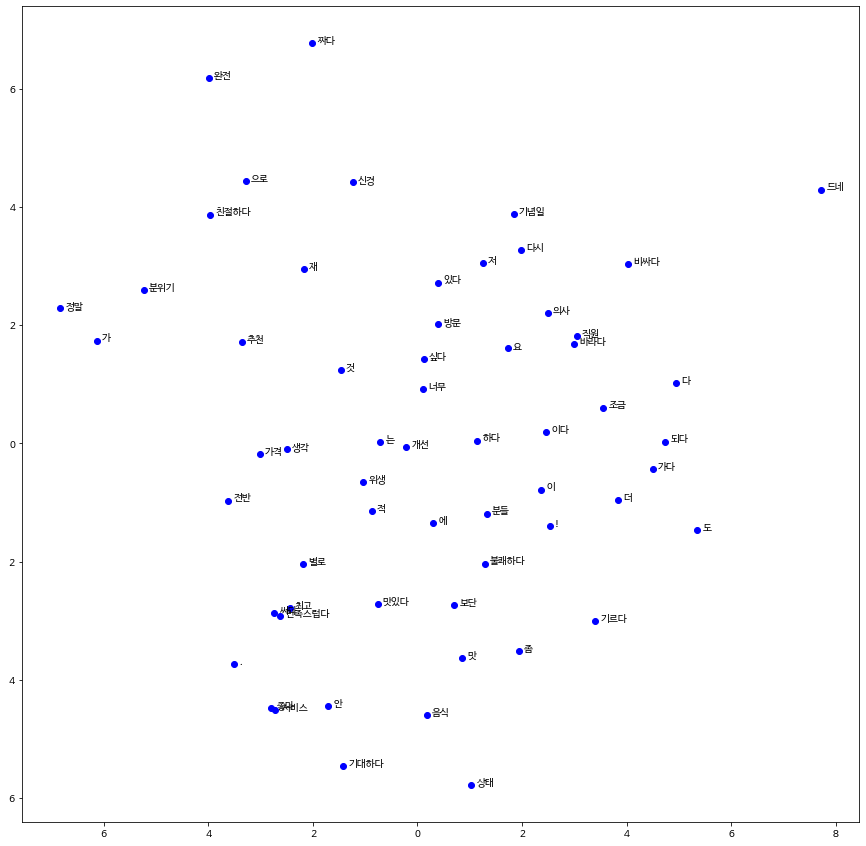

In [31]:
pc_weight=pca.fit_transform(skipgram.embedding.weight.data.cpu().numpy())
plt.figure(figsize=(15,15))
for word_id,(x_coordinate,y_coordinate) in enumerate(pc_weight):
  plt.scatter(x_coordinate,y_coordinate,color="blue")
  plt.annotate(i2w[word_id], (x_coordinate+0.1, y_coordinate))

/home/koowater/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


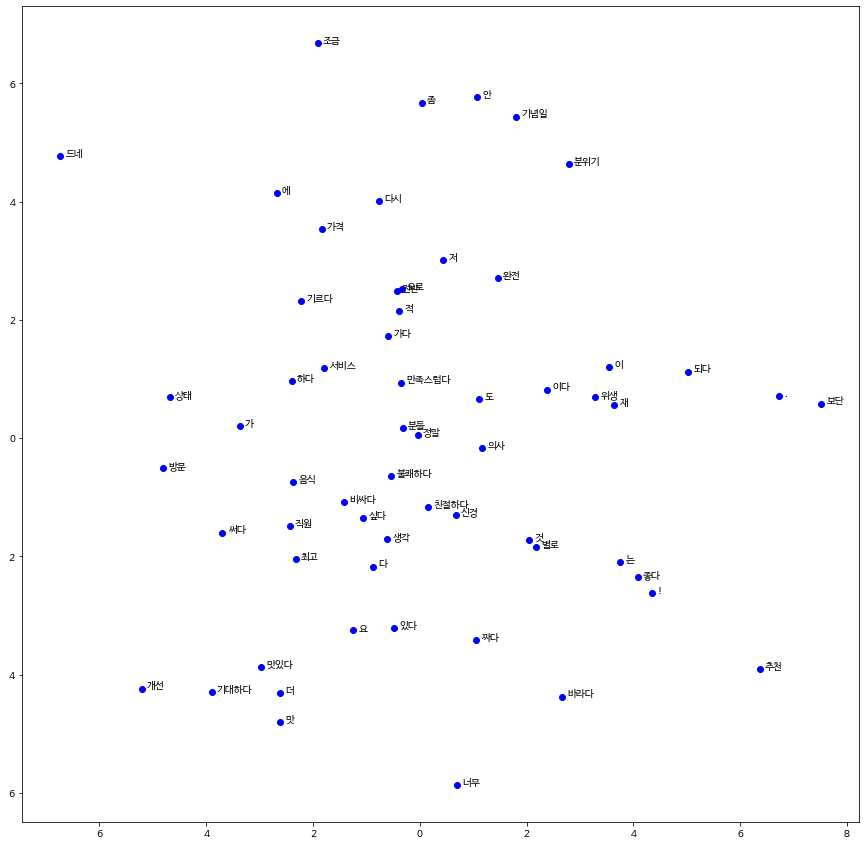

In [32]:
pc_weight=pca.fit_transform(cbow.embedding.weight.data.cpu().numpy())
plt.figure(figsize=(15,15))
for word_id,(x_coordinate,y_coordinate) in enumerate(pc_weight):
  plt.scatter(x_coordinate,y_coordinate,color="blue")
  plt.annotate(i2w[word_id], (x_coordinate+0.1, y_coordinate))

In [64]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=train_tokenized, vector_size=100, window=2, min_count=1, workers=4, sg=0)

In [73]:
print(model.wv.most_similar('너무')[:3])

[('하다', 0.252762109041214), ('최고', 0.2012740522623062), ('는', 0.1956762671470642)]


60